# Agentic Metric — Evaluating Complete Agent Conversations

The **Agentic** metric evaluates agent conversations as **complete units**. A conversation is correct only if **ALL** its interactions are correct.

## What It Measures

- **Answer Correctness**: Each interaction is scored by an LLM judge against a ground truth answer
- **Tool Correctness** *(optional)*: Evaluates tool selection, parameters, sequence, and result utilization
- **pass@K**: Probability of ≥1 fully correct conversation in K independent attempts
- **pass^K**: Probability of K consecutive fully correct conversations

## Formulas

```
pass@k = 1 - (1 - p)^k   # At least 1 correct in k independent attempts
pass^k = p^k              # All k attempts correct

Where p = c/n  (estimated success rate from evaluation)
```

- **n** = total conversations evaluated
- **c** = fully correct conversations
- **p** = c/n, the agent's estimated success probability
- **k** = number of attempts — **not bounded by n**, you choose it based on your deployment scenario

> **Key insight**: A conversation with 9/10 correct interactions is still a *failure* — the agent must get every turn right.

## Installation

Install Fair Forge with agentic support and a LangChain LLM provider:

In [ ]:
!pip install alquimia-fair-forge[agentic] langchain-groq

## Imports

`pass_at_k` and `pass_pow_k` are standalone functions — you call them directly to aggregate results with your chosen K.

In [14]:
import json
from pathlib import Path

from langchain_groq import ChatGroq

from fair_forge import Retriever
from fair_forge.metrics.agentic import Agentic, pass_at_k, pass_pow_k
from fair_forge.schemas import Batch, Dataset

## API Key

This example uses [Groq](https://console.groq.com) — a fast, free LLM API. Create a free account to get your key.

In [15]:
import getpass

GROQ_API_KEY = getpass.getpass('Enter your Groq API key: ')

## Dataset Format

Each `Dataset` is **one complete conversation**. The `conversation` list holds `Batch` objects — one per interaction turn.

For tool evaluation, each `Batch` optionally includes:
- `agentic` — the tools the agent **actually used**
- `ground_truth_agentic` — the tools that were **expected**

```python
Dataset(
    session_id='run_001',           # Unique conversation ID
    assistant_id='agent_v1',        # Agent being evaluated
    language='english',
    context='System prompt',
    conversation=[
        Batch(
            qa_id='q1',
            query='What is 15 + 27?',
            assistant='15 + 27 = 42',           # Agent response
            ground_truth_assistant='42',         # Expected answer
            agentic={
                'tools_used': [
                    {'tool_name': 'calculator', 'parameters': {'operation': 'add', 'a': 15, 'b': 27}, 'step': 1}
                ],
                'final_answer_uses_tools': True
            },
            ground_truth_agentic={
                'expected_tools': [
                    {'tool_name': 'calculator', 'parameters': {'operation': 'add', 'a': 15, 'b': 27}, 'step': 1}
                ],
                'tool_sequence_matters': False
            }
        )
    ]
)
```

The included `dataset_agentic.json` contains **3 runs** of the same scenario with different agent responses — a typical setup for pass@K evaluation where you want to know how reliably an agent handles a given task.

## Retriever

Implement a `Retriever` subclass to load your conversations. The fallback data below (used when the JSON file is not found) has 3 runs: 2 fully correct and 1 that fails on the first question.

In [ ]:
class AgentRetriever(Retriever):
    def load_dataset(self) -> list[Dataset]:
        dataset_path = Path('dataset_agentic.json')

        if dataset_path.exists():
            with open(dataset_path) as f:
                return [Dataset.model_validate(data) for data in json.load(f)]

## Preview Dataset

In [44]:
retriever = AgentRetriever()
datasets = retriever.load_dataset()

print(f'Conversations loaded: {len(datasets)}\n')
print(f'{"#":<4} {"session_id":<35} {"assistant_id":<20} {"turns"}')
print('-' * 75)
for i, ds in enumerate(datasets, 1):
    print(f'{i:<4} {ds.session_id:<35} {ds.assistant_id:<20} {len(ds.conversation)}')

Conversations loaded: 1

#    session_id                          assistant_id         turns
---------------------------------------------------------------------------
1    single_long_conversation_001        agent_response_single 13


## Judge Model

The LLM judge evaluates answer correctness for each interaction. Use a capable model — larger models give more reliable scores.

In [45]:
judge_model = ChatGroq(
    model='llama-3.3-70b-versatile',
    api_key=GROQ_API_KEY,
    temperature=0.0,
)

## Run Evaluation

`Agentic.run()` evaluates each `Dataset` as a complete conversation.

**Key parameters:**
- `threshold` — minimum LLM judge score (0–1) for an answer to be correct. Default: `0.7`
- `tool_threshold` — minimum overall score for tool usage to be correct. Default: `1.0`
- `verbose` — print detailed per-interaction logs

In [46]:
metrics = Agentic.run(
    AgentRetriever,
    model=judge_model,
    k=2,
    threshold=0.7,
    tool_threshold=1.0,
    verbose=True,
)

print(f'\nEvaluation complete — {len(metrics)} conversations processed')

2026-02-18 16:25:29,969 - fair_forge.utils.logging - INFO - Loaded dataset with 1 batches
2026-02-18 16:25:29,973 - fair_forge.utils.logging - INFO - Initialized Agentic metric with model: ChatGroq
2026-02-18 16:25:29,974 - fair_forge.utils.logging - INFO - Thresholds - Answer: 0.7, Tool: 1.0
2026-02-18 16:25:29,975 - fair_forge.utils.logging - INFO - [Agentic] Evaluating 1 conversations
2026-02-18 16:25:29,976 - fair_forge.utils.logging - INFO - [Agentic] Evaluating conversation 1/1: single_long_conversation_001 (13 interactions)
2026-02-18 16:25:29,978 - fair_forge.utils.logging - DEBUG -   Interaction 1/13 (qa_id: q1_math)
2026-02-18 16:25:31,874 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-18 16:25:31,894 - fair_forge.utils.logging - DEBUG - Judge returned - reasoning: None...
2026-02-18 16:25:31,894 - fair_forge.utils.logging - DEBUG - ✓ Judge result type: <class 'fair_forge.metrics.agentic.AnswerCorrectnessOutput'>



Evaluation complete — 1 conversations processed


## Per-Conversation Results

Each `AgenticMetric` represents one complete conversation:

| Field | Description |
|-------|-------------|
| `is_fully_correct` | `True` only if **all** interactions passed the threshold |
| `correct_interactions / total_interactions` | Count of correct turns |
| `correctness_scores` | LLM judge score per turn (0.0–1.0) |
| `tool_correctness_scores` | Tool evaluation per turn (`None` if no tools were used) |

In [47]:
print('=' * 70)
print(f'{"PER-CONVERSATION RESULTS":^70}')
print('=' * 70)

for i, m in enumerate(metrics, 1):
    status = '✅ CORRECT' if m.is_fully_correct else '❌ FAILED'
    p = m.correct_interactions / m.total_interactions if m.total_interactions else 0
    print(f'\n[{i}] {m.session_id} / {m.assistant_id}')
    print(f'    Status : {status}')
    print(f'    Turns  : {m.correct_interactions}/{m.total_interactions} correct  (p = {p:.1%})')
    print(f'    Scores : {[round(s, 2) for s in m.correctness_scores]}')
    print(f'    pass@{m.k} = {m.pass_at_k:.4f}   pass^{m.k} = {m.pass_pow_k:.4f}')

    tool_scores = [t for t in m.tool_correctness_scores if t is not None]
    if tool_scores:
        tool_summary = [f'{round(t.overall_correctness, 2)} (ok)' if t.is_correct else f'{round(t.overall_correctness, 2)} (fail)' for t in tool_scores]
        print(f'    Tools  : {tool_summary}')

print('\n' + '=' * 70)

                       PER-CONVERSATION RESULTS                       

[1] single_long_conversation_001 / agent_response_single
    Status : ❌ FAILED
    Turns  : 7/13 correct  (p = 53.8%)
    Scores : [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
    pass@2 = 0.7870   pass^2 = 0.2899



## Aggregated Metrics: pass@K and pass^K

`pass_at_k` and `pass_pow_k` are standalone functions — you compute the aggregation yourself using **n** and **c** from the results above.

**K** is a deployment parameter you choose based on your use case:

| K | Question answered |
|---|---|
| 1 | What is the agent's base success rate? |
| 3 | If I run the agent 3 times on a task, what's the chance at least one succeeds? |
| 5 | For a high-stakes task with 5 attempts, how confident can I be? |

In [48]:
K = metrics[0].k

print(f'Summary table  (K = {K})\n')
print(f'{"#":<4} {"session / assistant":<42} {"turns":<10} {"p=c/n":<10} {"pass@K":<12} {"pass^K"}')
print('-' * 85)
for i, m in enumerate(metrics, 1):
    label = f'{m.session_id} / {m.assistant_id}'
    p = m.correct_interactions / m.total_interactions if m.total_interactions else 0
    print(f'{i:<4} {label:<42} {m.correct_interactions}/{m.total_interactions:<8} {p:<10.1%} {m.pass_at_k:<12.4f} {m.pass_pow_k:.4f}')

Summary table  (K = 2)

#    session / assistant                        turns      p=c/n      pass@K       pass^K
-------------------------------------------------------------------------------------
1    single_long_conversation_001 / agent_response_single 7/13       53.8%      0.7870       0.2899


## Compare K Values

See how pass@K and pass^K change as K increases — pass@K grows (easier to succeed at least once), pass^K shrinks (harder to succeed every time).

In [49]:
k_range = list(range(1, 11))
col_w = 14

# pass@K table
print('pass@K per conversation\n')
header = f'{"K":<6}' + ''.join(f'{m.assistant_id[:col_w-2]:<{col_w}}' for m in metrics)
print(header)
print('-' * (6 + col_w * len(metrics)))
for k in k_range:
    row = f'k={k:<4}'
    for m in metrics:
        row += f'{pass_at_k(m.total_interactions, m.correct_interactions, k):<{col_w}.4f}'
    print(row)

print()

# pass^K table
print('pass^K per conversation\n')
print(header)
print('-' * (6 + col_w * len(metrics)))
for k in k_range:
    row = f'k={k:<4}'
    for m in metrics:
        row += f'{pass_pow_k(m.total_interactions, m.correct_interactions, k):<{col_w}.4f}'
    print(row)

pass@K per conversation

K     agent_respon  
--------------------
k=1   0.5385        
k=2   0.7870        
k=3   0.9017        
k=4   0.9546        
k=5   0.9791        
k=6   0.9903        
k=7   0.9955        
k=8   0.9979        
k=9   0.9990        
k=10  0.9996        

pass^K per conversation

K     agent_respon  
--------------------
k=1   0.5385        
k=2   0.2899        
k=3   0.1561        
k=4   0.0841        
k=5   0.0453        
k=6   0.0244        
k=7   0.0131        
k=8   0.0071        
k=9   0.0038        
k=10  0.0020        


## Visualization

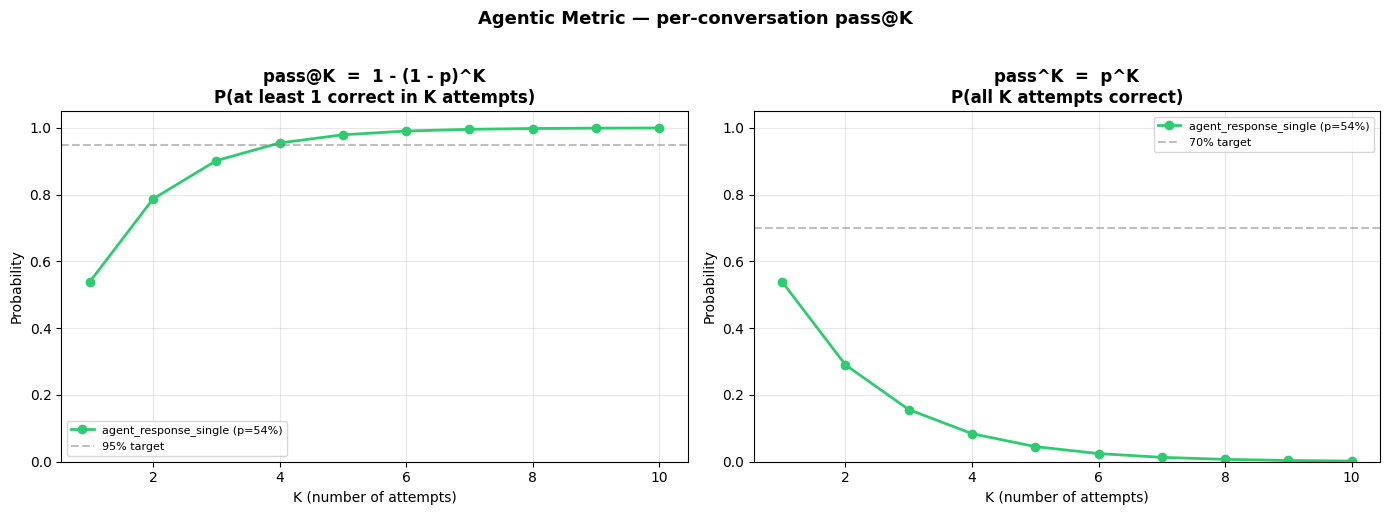

In [50]:
import matplotlib.pyplot as plt

k_range = list(range(1, 11))
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f39c12']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for i, m in enumerate(metrics):
    color = colors[i % len(colors)]
    label = m.assistant_id
    p = m.correct_interactions / m.total_interactions if m.total_interactions else 0
    pak_values = [pass_at_k(m.total_interactions, m.correct_interactions, k) for k in k_range]
    ppk_values = [pass_pow_k(m.total_interactions, m.correct_interactions, k) for k in k_range]
    ax1.plot(k_range, pak_values, 'o-', color=color, linewidth=2, markersize=6, label=f'{label} (p={p:.0%})')
    ax2.plot(k_range, ppk_values, 'o-', color=color, linewidth=2, markersize=6, label=f'{label} (p={p:.0%})')

ax1.axhline(y=0.95, color='gray', linestyle='--', alpha=0.5, label='95% target')
ax1.set_xlabel('K (number of attempts)')
ax1.set_ylabel('Probability')
ax1.set_title('pass@K  =  1 - (1 - p)^K\nP(at least 1 correct in K attempts)', fontweight='bold')
ax1.set_ylim(0, 1.05)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=8)

ax2.axhline(y=0.7, color='gray', linestyle='--', alpha=0.5, label='70% target')
ax2.set_xlabel('K (number of attempts)')
ax2.set_ylabel('Probability')
ax2.set_title('pass^K  =  p^K\nP(all K attempts correct)', fontweight='bold')
ax2.set_ylim(0, 1.05)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=8)

plt.suptitle('Agentic Metric — per-conversation pass@K', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Interpreting Results

### pass@K — "Can the agent succeed at all?"

pass@K answers: *"If I give the agent K independent attempts, what's the probability it produces at least one fully correct conversation?"*

| Success Rate (c/n) | pass@1 | pass@3 | pass@5 |
|---|---|---|---|
| 20% (2/10 correct) | 20% | 49% | 67% |
| 50% (5/10 correct) | 50% | 88% | 97% |
| 80% (8/10 correct) | 80% | 99% | ~100% |

### pass^K — "Is the agent consistent?"

pass^K answers: *"What's the probability that K consecutive attempts are ALL correct?"*

At 50% success rate: pass^1 = 50%, pass^3 = 12.5%, pass^5 = 3.1%.

**High pass@K + Low pass^K** → The agent *can* succeed but is inconsistent.  
**Both high** → The agent is reliable.

### Agent Classification

| pass@1 | pass^3 | Classification |
|--------|--------|----------------|
| > 90% | > 70% | ✅ Production-ready |
| > 90% | 30–70% | ⚠️ Functional but inconsistent |
| 70–90% | — | 🔶 Needs improvement |
| < 70% | — | ❌ Not ready |

## Key Takeaways

1. **All-or-nothing evaluation**: A conversation passes only if every interaction is correct — this reflects the strict requirements of real agentic systems
2. **You control K**: Call `pass_at_k(n, c, k)` and `pass_pow_k(n, c, k)` directly with your chosen K — no wrapper method needed
3. **Tool correctness is optional**: Add `agentic` and `ground_truth_agentic` fields to `Batch` objects when you want to evaluate tool usage alongside answer correctness
4. **More data = better estimates**: Evaluate more conversations to get statistically reliable pass@K values

### Resources
- [Fair Forge Documentation](https://docs.alquimia.ai)
- [pass@K paper (Chen et al. 2021)](https://arxiv.org/abs/2107.03374)
- [GitHub](https://github.com/Alquimia-ai/fair-forge)